# Importing the dataset and data exploration

The AG News dataset is used for this assignment

In [1]:
import numpy as np

In [2]:
from datasets import load_dataset
ds = load_dataset("ag_news")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [3]:
train_full = ds["train"]
test_full  = ds["test"]

print(train_full)
print(test_full)

print("\nDisplay a few samples:")
for i in range(5):
    print("\n", train_full[np.random.randint(train_full.num_rows)])

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})

Display a few samples:

 {'text': "Flash dims AMD's revenue outlook The chipmaker's warning raises concerns about the flash memory business, one financial analyst says in a report.", 'label': 3}

 {'text': "They're quick to impress ATHENS -- Another night, another strong showing for America's sprinters. Allyson Felix , at 18 years old the youngest of the young lions, cruised to victory in her 200-meter heat, and then easily won her semifinal heat (22.36) to advance to the finals.", 'label': 1}

 {'text': 'Viacom Starts Blockbuster Exchange Offer Viacom Inc. (VIAb.N: Quote, Profile, Research) has begun a share exchange offer to split off its Blockbuster Inc. (BBI.N: Quote, Profile, Research) unit and put the video rental chain ', 'label': 2}

 {'text': "Microsoft Delays SP2 Delivery--Again Software giant allows users more time to prepare for XP's security 

In [4]:
from collections import Counter

label_names = train_full.features["label"].names
print("Label names:", label_names)

train_label_counts = Counter(train_full["label"])
test_label_counts  = Counter(test_full["label"])

print("\nTrain label counts:")
for idx, name in enumerate(label_names):
    print(f"  {idx} - {name}: {train_label_counts[idx]}")

print("\nTest label counts:")
for idx, name in enumerate(label_names):
    print(f"  {idx} - {name}: {test_label_counts[idx]}")

Label names: ['World', 'Sports', 'Business', 'Sci/Tech']

Train label counts:
  0 - World: 30000
  1 - Sports: 30000
  2 - Business: 30000
  3 - Sci/Tech: 30000

Test label counts:
  0 - World: 1900
  1 - Sports: 1900
  2 - Business: 1900
  3 - Sci/Tech: 1900


- the classes are perfectly balanced in this dataset

Let's split the data into train, validation and test sets using stratification to keep the class ratio (though it could just be random since the classes are well-balanced)

In [5]:
split = train_full.train_test_split(
    test_size=0.1,
    stratify_by_column="label",
    seed=99,
)

train_raw = split["train"]
val_raw   = split["test"]
test_raw  = test_full  # keep HF test as final test set

print("Sizes:")
print("  train:", len(train_raw))
print("  val:  ", len(val_raw))
print("  test: ", len(test_raw))

Sizes:
  train: 108000
  val:   12000
  test:  7600


In [6]:
print("train label counts:", Counter(train_raw["label"]))
print("val label counts:  ", Counter(val_raw["label"]))
print("test label counts: ", Counter(test_raw["label"]))

train label counts: Counter({0: 27000, 1: 27000, 2: 27000, 3: 27000})
val label counts:   Counter({3: 3000, 1: 3000, 0: 3000, 2: 3000})
test label counts:  Counter({2: 1900, 3: 1900, 1: 1900, 0: 1900})


In [7]:
import statistics

def text_length_stats(ds, name):
    lengths = [len(example["text"].split()) for example in ds]
    print(f"{name}:")
    print("  N samples:", len(lengths))
    print("  min words:", min(lengths))
    print("  max words:", max(lengths))
    print("  mean words:", round(statistics.mean(lengths), 1))
    print("  median words:", statistics.median(lengths))

text_length_stats(train_raw, "Train")
text_length_stats(val_raw,   "Val")
text_length_stats(test_raw,  "Test")

Train:
  N samples: 108000
  min words: 8
  max words: 177
  mean words: 37.8
  median words: 37.0
Val:
  N samples: 12000
  min words: 8
  max words: 151
  mean words: 37.9
  median words: 37.0
Test:
  N samples: 7600
  min words: 11
  max words: 137
  mean words: 37.7
  median words: 37.0


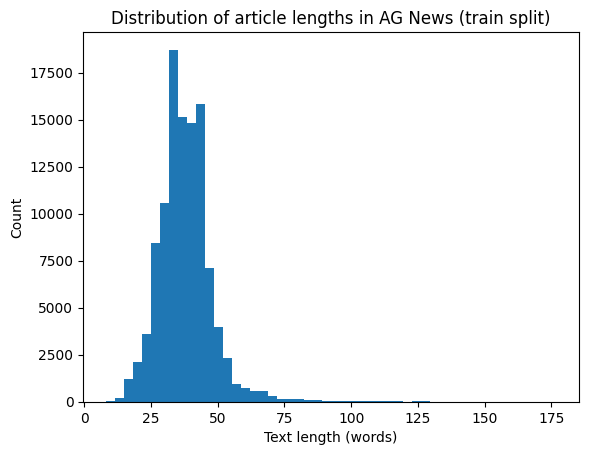

In [8]:
import matplotlib.pyplot as plt

lengths_train = [len(example["text"].split()) for example in train_raw]
plt.hist(lengths_train, bins=50)
plt.xlabel("Text length (words)")
plt.ylabel("Count")
plt.title("Distribution of article lengths in AG News (train split)")
plt.show()

# Dataset Tokenization

- most text lengths are around 38 words - and the majority fall under 50 words
- since available tokenizers (like GPT-2’s BPE tokenizer) typically need around 1.5 tokens / word (just an estimate)
    - 1.5 * 50 = 75 tokens
- I will assume the sequence of 128 to be sufficient for each sample  

In [33]:
from transformers import GPT2TokenizerFast
from torch.utils.data import DataLoader

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token   # GPT-2 has no pad token by default and we need it for masking the input samples - shorter ones get padded so that all have a fixed length
MAX_LEN = 32

print("Vocab size:", tokenizer.vocab_size)
print("Pad token id:", tokenizer.pad_token_id)

Vocab size: 50257
Pad token id: 50256


In [10]:
# tokenize splits
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],          # a LIST of raw text strings
        truncation=True,        # cut off sequences longer than max_length
        padding="max_length",   # pad all sequences in batch to length MAX_LEN
        max_length=MAX_LEN,     # the chosen sequence length
    )

train_tok = train_raw.map(tokenize_batch, batched=True)
val_tok   = val_raw.map(tokenize_batch, batched=True)
test_tok  = test_raw.map(tokenize_batch, batched=True)

cols = ["input_ids", "attention_mask", "label"]
for ds_tok in (train_tok, val_tok, test_tok):
    ds_tok.set_format(type="torch", columns=cols)

# dataloaders for from-scratch model
train_loader = DataLoader(train_tok, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_tok, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_tok, batch_size=64, shuffle=False)

batch = next(iter(train_loader))
print("Batch shapes:")
print("  input_ids:      ", batch["input_ids"].shape)      # (B, 128)
print("  attention_mask: ", batch["attention_mask"].shape) # (B, 128)
print("  labels:         ", batch["label"].shape)          # (B,)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Batch shapes:
  input_ids:       torch.Size([16, 128])
  attention_mask:  torch.Size([16, 128])
  labels:          torch.Size([16])


# Fine-tuning GPT-2 as a classifier

- At first "gpt2" was used but for cpu and unrestricted training dataset it yealded 40h worth of training for one epoch on cpu
- it was therefore changed to "distilgpt2" since it has less parameters
- the training dataset used was also restricted to a subset of 5k (can be increased if on cpu)
- since freezing all transformer weights allowed for quicker training but with a significantly lower classification accuracy, I stuck to training without the weights frozen - slightly longer per epoch but starting at a significantly  higher classification accuracy, requiring less epochs to train to obtain good results 

In [28]:
import time
import numpy as np
import torch
import evaluate
from transformers import (
    GPT2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

# model config
model_name = "distilgpt2"   # smaller, faster than full gpt2
# model_name = "gpt2"

num_labels = len(train_full.features["label"].names)
label_names = train_full.features["label"].names
print("Labels:", label_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# metrics calculations - accuracy + macro F1
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = f1_metric.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["f1"]
    return {"accuracy": acc, "f1_macro": f1_macro}

Labels: ['World', 'Sports', 'Business', 'Sci/Tech']
Using device: cpu


In [29]:
# load pre-trained GPT-2 for sequence classification
model_ft = GPT2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
)

# use the same pad token as in the tokenizer
model_ft.config.pad_token_id = tokenizer.pad_token_id

model_ft.to(device)

# count trainable vs total parameters
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Total params:      {total_params}")
print(f"Trainable params:  {trainable_params}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total params:      81915648
Trainable params:  81915648


In [ ]:
training_args = TrainingArguments(
    output_dir="checkpoints/gpt2_full",
    eval_strategy="epoch",       # eval at end of each epoch
    save_strategy="epoch",             # save checkpoint each epoch
    learning_rate=5e-5,                # smaller LR for fine-tuning
    per_device_train_batch_size=4,     # small per-device batch
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,     # effective train batch size ≈ 4*4 = 16
    num_train_epochs=2,                # we will likely stop earlier via ES
    weight_decay=0.01,                 # L2 regularization
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=100,
    save_total_limit=2,
    report_to="none",                  # disable wandb etc.
)

In [ ]:
# set a smaller training subset to keep runtime reasonable
N_TRAIN = 500
train_tok_small = train_tok.select(range(N_TRAIN))
print("Train subset size:", len(train_tok_small))


trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=train_tok_small,
    eval_dataset=val_tok,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

Train subset size: 5000


In [32]:
# train and measure training time
start_train = time.time()
train_result = trainer.train()
end_train = time.time()
ft_train_time = end_train - start_train
print(f"Fine-tuning training time (s): {ft_train_time:.1f}")

# evaluate on test set and measure inference time
start_eval = time.time()
test_metrics = trainer.evaluate(test_tok)
end_eval = time.time()
ft_inference_time = end_eval - start_eval

print("Fine-tuned test metrics:", test_metrics)
print(f"Inference time on test (s): {ft_inference_time:.1f}")

/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Weight-frozen training

In [ ]:
model_ft = GPT2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
)

model_ft.config.pad_token_id = tokenizer.pad_token_id

# freeze transformer, train only classification head
# freeze all transformer layers
for param in model_ft.transformer.parameters():
    param.requires_grad = False

# ensure classification head is trainable
for param in model_ft.score.parameters():
    param.requires_grad = True

model_ft.to(device)

# count trainable vs total parameters
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Total params:      {total_params}")
print(f"Trainable params:  {trainable_params}")

In [ ]:
training_args = TrainingArguments(
    output_dir="checkpoints/gpt2_frozen",
    eval_strategy="epoch",       # eval at end of each epoch
    save_strategy="epoch",             # save checkpoint each epoch
    learning_rate=5e-5,                # smaller LR for fine-tuning
    per_device_train_batch_size=4,     # small per-device batch
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,     # effective train batch size ≈ 4*4 = 16
    num_train_epochs=2,                # we will likely stop earlier via ES
    weight_decay=0.01,                 # L2 regularization
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=100,
    save_total_limit=2,
    report_to="none",                  # disable wandb etc.
)

In [ ]:
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=train_tok_small,
    eval_dataset=val_tok,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

In [ ]:
# train and measure training time
start_train = time.time()
train_result = trainer.train()
end_train = time.time()
ft_train_time = end_train - start_train
print(f"Fine-tuning training time (s): {ft_train_time:.1f}")

# evaluate on test set and measure inference time
start_eval = time.time()
test_metrics = trainer.evaluate(test_tok)
end_eval = time.time()
ft_inference_time = end_eval - start_eval

print("Fine-tuned test metrics:", test_metrics)
print(f"Inference time on test (s): {ft_inference_time:.1f}")

# The from-scratch GPT-like model

In [ ]:
from torch.utils.data import DataLoader

# For fair comparison, use the same subset as for fine-tuning
# (if you used N_TRAIN before, reuse it; otherwise set it here)
N_TRAIN = 500
train_tok_small = train_tok.select(range(N_TRAIN))

batch_size_train = 16
batch_size_eval = 64

train_loader_scratch = DataLoader(train_tok_small, batch_size=batch_size_train, shuffle=True)
val_loader_scratch   = DataLoader(val_tok,         batch_size=batch_size_eval,   shuffle=False)
test_loader_scratch  = DataLoader(test_tok,        batch_size=batch_size_eval,   shuffle=False)

batch = next(iter(train_loader_scratch))
print("Scratch train batch shapes:")
print("  input_ids:      ", batch["input_ids"].shape)
print("  attention_mask: ", batch["attention_mask"].shape)
print("  labels:         ", batch["label"].shape)

Scratch train batch shapes:
  input_ids:       torch.Size([16, 128])
  attention_mask:  torch.Size([16, 128])
  labels:          torch.Size([16])


In [24]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyGPTClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        num_labels: int,
        max_len: int = 128,
        d_model: int = 128,
        n_heads: int = 4,
        n_layers: int = 2,
        dim_ff: int = 512,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_labels = num_labels
        self.d_model = d_model
        self.max_len = max_len

        # Token and positional embeddings
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb   = nn.Embedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,   # [B, T, D]
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers,
        )

        self.dropout = nn.Dropout(dropout)

        # Classification head: simple linear layer
        self.classifier = nn.Linear(d_model, num_labels)

        self._init_weights()

    def _init_weights(self):
        # Initialize weights reasonably
        nn.init.normal_(self.token_emb.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_emb.weight,   mean=0.0, std=0.02)
        nn.init.normal_(self.classifier.weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, input_ids, attention_mask):
        """
        input_ids:      [B, T]
        attention_mask: [B, T] with 1 for real tokens, 0 for padding
        """
        B, T = input_ids.shape
        device = input_ids.device

        # 1) Embeddings
        pos_ids = torch.arange(T, device=device).unsqueeze(0).expand(B, T)  # [B, T]
        x = self.token_emb(input_ids) + self.pos_emb(pos_ids)              # [B, T, D]
        x = self.dropout(x)

        # 2) Optional causal mask for decoder-style behavior
        #    (upper triangular mask to prevent attending to future tokens)
        #    For classification, this is not critical, but it makes it "decoder-like".
        attn_mask = None
        # If you want causal mask:
        # attn_mask = torch.triu(torch.ones(T, T, device=device) * float("-inf"), diagonal=1)

        # 3) Apply transformer encoder (with batch_first=True)
        #    src_key_padding_mask expects True for padding tokens
        src_key_padding_mask = (attention_mask == 0)  # [B, T], True where padding
        h = self.transformer(
            x,
            mask=attn_mask,
            src_key_padding_mask=src_key_padding_mask,
        )  # [B, T, D]

        # 4) Mean pooling over non-padded tokens
        mask = attention_mask.unsqueeze(-1)  # [B, T, 1]
        h_masked = h * mask                  # zero out padding
        sum_h = h_masked.sum(dim=1)         # [B, D]
        lengths = mask.sum(dim=1).clamp(min=1)  # [B, 1]
        pooled = sum_h / lengths            # [B, D]

        pooled = self.dropout(pooled)

        # 5) Classification head
        logits = self.classifier(pooled)    # [B, num_labels]
        return logits

In [25]:
from transformers import get_linear_schedule_with_warmup

def train_scratch_model(
    model,
    train_loader,
    val_loader,
    num_epochs: int = 5,
    base_lr: float = 3e-4,
    weight_decay: float = 0.01,
    max_grad_norm: float = 1.0,
    warmup_ratio: float = 0.1,
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=base_lr,
        weight_decay=weight_decay,
    )

    num_training_steps = num_epochs * len(train_loader)
    num_warmup_steps = int(warmup_ratio * num_training_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
    )

    criterion = nn.CrossEntropyLoss()

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }

    from sklearn.metrics import accuracy_score, f1_score

    global_step = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            logits = model(input_ids, attention_mask)   # [B, num_labels]
            loss = criterion(logits, labels)

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()
            global_step += 1

            running_loss += loss.item() * input_ids.size(0)

        train_loss_epoch = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_losses = []
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_losses.append(loss.item() * input_ids.size(0))

                preds = torch.argmax(logits, dim=-1)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())

        val_loss_epoch = sum(val_losses) / len(val_loader.dataset)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average="macro")

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss_epoch)
        history["val_loss"].append(val_loss_epoch)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(
            f"Epoch {epoch:02d} | "
            f"train_loss={train_loss_epoch:.4f} | "
            f"val_loss={val_loss_epoch:.4f} | "
            f"val_acc={val_acc:.4f} | "
            f"val_f1={val_f1:.4f}"
        )

    return history

In [ ]:
vocab_size = tokenizer.vocab_size
num_labels = len(train_full.features["label"].names)

tiny_model = TinyGPTClassifier(
    vocab_size=vocab_size,
    num_labels=num_labels,
    max_len=MAX_LEN,
    d_model=128,
    n_heads=4,
    n_layers=2,
    dim_ff=512,
    dropout=0.1,
)

history_scratch = train_scratch_model(
    tiny_model,
    train_loader_scratch,
    val_loader_scratch,
    num_epochs=5,
    base_lr=3e-4,
)

/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 01 | train_loss=0.9757 | val_loss=0.4655 | val_acc=0.8349 | val_f1=0.8341
Epoch 02 | train_loss=0.2170 | val_loss=0.4683 | val_acc=0.8604 | val_f1=0.8605
Epoch 03 | train_loss=0.0383 | val_loss=0.6199 | val_acc=0.8641 | val_f1=0.8644
Epoch 04 | train_loss=0.0081 | val_loss=0.6553 | val_acc=0.8718 | val_f1=0.8711
Epoch 05 | train_loss=0.0017 | val_loss=0.6607 | val_acc=0.8738 | val_f1=0.8733


In [27]:
from sklearn.metrics import accuracy_score, f1_score

def eval_on_test(model, test_loader, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    import time
    start = time.time()

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    end = time.time()
    total_time = end - start

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    return {"accuracy": acc, "f1_macro": f1_macro, "inference_time_s": total_time}

scratch_test_metrics = eval_on_test(tiny_model, test_loader_scratch)
print("Scratch test metrics:", scratch_test_metrics)

scratch_param_count = sum(p.numel() for p in tiny_model.parameters())
print("Scratch model parameter count:", scratch_param_count)

Scratch test metrics: {'accuracy': 0.8607894736842105, 'f1_macro': 0.8602538755104127, 'inference_time_s': 3.532940626144409}
Scratch model parameter count: 6846340
